In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.preprocessing import sequence

from TransformerComplet import *

from tensorflow.keras.layers import Dense, Dropout, Embedding, Input, Concatenate, MultiHeadAttention


In [2]:

# 1. Prétraitement des Données
benign_stateful_1 = pd.read_csv('../../data/Attack_Benin_2/Benign/Benign/stateful_features-benign_heavy_1.pcap.csv')
benign_stateful_2 = pd.read_csv('../../data/Attack_Benin_2/Benign/Benign/stateful_features-benign_heavy_2.pcap.csv')
benign_stateful_3 = pd.read_csv('../../data/Attack_Benin_2/Benign/Benign/stateful_features-benign_heavy_3.pcap.csv')

benign_stateless_1 = pd.read_csv('../../data/Attack_Benin_2/Benign/Benign/stateless_features-benign_heavy_1.pcap.csv')
benign_stateless_2 = pd.read_csv('../../data/Attack_Benin_2/Benign/Benign/stateless_features-benign_heavy_2.pcap.csv')
benign_stateless_3 = pd.read_csv('../../data/Attack_Benin_2/Benign/Benign/stateless_features-benign_heavy_3.pcap.csv')

attack_stateful_1 = pd.read_csv('../../data/Attack_Benin_2/Attacks/Attacks/stateful_features-heavy_audio.pcap.csv')
attack_stateful_2 = pd.read_csv('../../data/Attack_Benin_2/Attacks/Attacks/stateful_features-heavy_compressed.pcap.csv')
attack_stateful_3 = pd.read_csv('../../data/Attack_Benin_2/Attacks/Attacks/stateful_features-heavy_exe.pcap.csv')
attack_stateful_4 = pd.read_csv('../../data/Attack_Benin_2/Attacks/Attacks/stateful_features-heavy_image.pcap.csv')
attack_stateful_5 = pd.read_csv('../../data/Attack_Benin_2/Attacks/Attacks/stateful_features-heavy_text.pcap.csv')
attack_stateful_6 = pd.read_csv('../../data/Attack_Benin_2/Attacks/Attacks/stateful_features-heavy_video.pcap.csv')

attack_stateless_1 = pd.read_csv('../../data/Attack_Benin_2/Attacks/Attacks/stateless_features-heavy_audio.pcap.csv')
attack_stateless_2 = pd.read_csv('../../data/Attack_Benin_2/Attacks/Attacks/stateless_features-heavy_compressed.pcap.csv')
attack_stateless_3 = pd.read_csv('../../data/Attack_Benin_2/Attacks/Attacks/stateless_features-heavy_exe.pcap.csv')
attack_stateless_4 = pd.read_csv('../../data/Attack_Benin_2/Attacks/Attacks/stateless_features-heavy_image.pcap.csv')
attack_stateless_5 = pd.read_csv('../../data/Attack_Benin_2/Attacks/Attacks/stateless_features-heavy_text.pcap.csv')
attack_stateless_6 = pd.read_csv('../../data/Attack_Benin_2/Attacks/Attacks/stateless_features-heavy_video.pcap.csv')



# Exemple pour les données Light Attack
merged_statful_heavy_attack = pd.concat([attack_stateful_1, attack_stateful_2, attack_stateful_3,attack_stateful_4,attack_stateful_5,attack_stateful_6], axis=0, ignore_index=True)
merged_stateless_light_attack = pd.concat([attack_stateless_1, attack_stateless_2, attack_stateless_3,attack_stateless_4,attack_stateless_5,attack_stateless_6], axis=0, ignore_index=True)


# Exemple intuitif pour les colonnes stateless

### (axis=0) car ils ont les memes colonnes donc ont empile ; (axis=1) colonne different on juxtapose
merged_stateless_benign = pd.concat([benign_stateless_1, benign_stateless_2, benign_stateless_3], axis=0, ignore_index=True)
merged_statful_benign = pd.concat([benign_stateful_1, benign_stateful_2, benign_stateful_3], axis=0, ignore_index=True)

# final_benign_data = pd.concat([merged_stateless_benign, merged_statful_benign], axis=1)


# Concaténation des données sans redondance
final_benign_data = pd.concat([merged_stateless_benign, merged_statful_benign], axis=1).loc[:, ~pd.concat([merged_stateless_benign, merged_statful_benign], axis=1).columns.duplicated()]
final_attack_data = pd.concat([merged_stateless_light_attack, merged_statful_heavy_attack], axis=1).loc[:, ~pd.concat([merged_stateless_light_attack, merged_statful_heavy_attack], axis=1).columns.duplicated()]

# Ajout des étiquettes après la concaténation


final_benign_data['label'] = 'benign'
final_attack_data['label'] = 'attack'




# Faites de même pour les autres fichiers CSV

In [3]:
print(final_benign_data.dtypes)
print(final_attack_data.dtypes)

print(final_attack_data.shape)
print(final_benign_data.shape)

final_attack_data.isnull().sum().sort_values(ascending=False)
final_benign_data.isnull().sum().sort_values(ascending=False)

# Afficher les noms des colonnes
print("Colonnes de final_benign_data:", final_benign_data.columns)



timestamp            object
FQDN_count            int64
subdomain_length      int64
upper                 int64
lower                 int64
numeric               int64
entropy             float64
special               int64
labels                int64
labels_max            int64
labels_average      float64
longest_word         object
sld                  object
len                   int64
subdomain             int64
rr                  float64
A_frequency         float64
NS_frequency        float64
CNAME_frequency     float64
SOA_frequency       float64
NULL_frequency      float64
PTR_frequency       float64
HINFO_frequency     float64
MX_frequency        float64
TXT_frequency       float64
AAAA_frequency      float64
SRV_frequency       float64
OPT_frequency       float64
rr_type              object
rr_count            float64
rr_name_entropy     float64
rr_name_length      float64
distinct_ns         float64
distinct_ip          object
unique_country       object
unique_asn          

In [4]:
# 2. Concaténer les données

final_data = pd.concat([final_benign_data, final_attack_data], axis=0, ignore_index=True)

# 3. Supprimer les colonnes redondantes dans les données catégorielles
final_data = final_data.loc[:, ~final_data.columns.duplicated()]

# 4. Séparer les caractéristiques numériques et catégorielles
X_numerical = final_data.select_dtypes(include='number')
X_categorical = final_data.select_dtypes(exclude='number')

# 5. Étiquettes
y = final_data['label']





In [5]:
print(X_numerical.shape)
print(X_categorical.shape)

print(y.shape)

(433364, 32)
(433364, 11)
(433364,)


In [6]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.impute import SimpleImputer


#prepocessing des features numeriques soit  avec le  LabelEncoder soit le MinMaxScaler()

# 2. Vérification des colonnes vides
if X_numerical.isnull().any().any():
    # Imputer les valeurs manquantes pour les caractéristiques numériques
    numerical_imputer = SimpleImputer(strategy='mean')
    X_numerical_imputed = pd.DataFrame(numerical_imputer.fit_transform(X_numerical), columns=X_numerical.columns)

    #prepocessing des features numeriques soit  avec le  LabelEncoder soit le MinMaxScaler()

    # Création d'un scaler
    scaler = MinMaxScaler()

    # Ajustement du scaler aux données
    scaler.fit(X_numerical_imputed)

    # Transformation des fonctionnalités numériques
    # scaled_numeric_features = scaler.transform(X_numerical_combined)

    scaled_numeric_features = scaler.transform(X_numerical_imputed)

    # Apres transformation Création d' un DataFrame à partir des valeurs transformées

    # scaled_df = pd.DataFrame(scaled_numeric_features, columns=X_numerical_combined.columns)
    scaled_df = pd.DataFrame(scaled_numeric_features, columns=X_numerical.columns)


    # Afficher le DataFrame avec les valeurs transformées
    print("Après transformation")
    print(scaled_df)

    total_size = scaled_df.shape

    print("Taille totale des caracteristiques numeriques apres concatenations :", total_size)

else:
    print("Pas de valeurs manquantes dans les caractéristiques numériques. Aucune imputation nécessaire.")

Après transformation
        FQDN_count  subdomain_length  upper     lower   numeric   entropy   
0         0.735294          0.344828    0.0  0.294118  0.916667  0.566700  \
1         0.735294          0.344828    0.0  0.294118  0.916667  0.545264   
2         0.735294          0.344828    0.0  0.294118  0.916667  0.545264   
3         0.647059          0.241379    0.0  0.294118  0.666667  0.442238   
4         0.882353          0.000000    1.0  0.000000  0.000000  0.606400   
...            ...               ...    ...       ...       ...       ...   
433359    0.647059          0.241379    0.0  0.294118  0.666667  0.442238   
433360    0.735294          0.344828    0.0  0.294118  0.916667  0.566700   
433361    0.735294          0.344828    0.0  0.294118  0.916667  0.566700   
433362    0.735294          0.344828    0.0  0.294118  0.916667  0.566700   
433363    0.735294          0.344828    0.0  0.294118  0.916667  0.566700   

        special    labels  labels_max  labels_average 

In [7]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder


# 6. Encodage des étiquettes
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [8]:
################################ Selection des meilleurs features Numeriques ####################################


from sklearn.tree import DecisionTreeRegressor #Comme estimateur pour la sélection des caractéristiques.
from sklearn.model_selection import StratifiedKFold #Pour effectuer une validation croisée stratifiée.
from sklearn.feature_selection import RFECV #La classe qui effectue la sélection de caractéristiques



def rfe_cross_validation(X, y, feature_number):
    # Créer une instance de RFECV avec l'estimateur précédemment produit 
    rfe_cv = RFECV(estimator=DecisionTreeRegressor(), step=1, cv=StratifiedKFold(10),
                   verbose=1, min_features_to_select=feature_number, n_jobs=4)

    # Ajuster RFECV sur les données
    rfe_cv.fit(X, y)

    # Transformer X pour ne conserver que les caractéristiques sélectionnées
    X_selected = rfe_cv.transform(X)

    # Créer un DataFrame avec les noms des caractéristiques et leurs importances
    feature_set = pd.DataFrame()
    # feature_set['attr'] = X.columns
    feature_set['attr'] = X.columns[rfe_cv.support_]  # Utiliser seulement les caractéristiques sélectionnées pour ne pas avoir un probleme de hors page/marge comme la ligne precedente
    feature_set['importance'] = rfe_cv.estimator_.feature_importances_

    # Trier par ordre décroissant d'importance
    feature_set = feature_set.sort_values(by='importance', ascending=False)

    # Retourner les noms des caractéristiques les plus importantes
    return feature_set['attr'].head(feature_number).values



# Appel de la fonction et impression des features importants
important_features_rfe = rfe_cross_validation(X_numerical_imputed, y_encoded, feature_number=10)
print("Caractéristiques importantes (RFECV):")
print(important_features_rfe)


Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Caractéristiques importantes (RFECV):
['FQDN_count' 'A_frequency' 'labels' 'subdomain_length' 'lower'
 'TXT_frequency' 'rr_name_entropy' 'labels_max' 'ttl_mean' 'entropy']


In [11]:
############# Il y'a un soucis il ne faut pas utiliser le (X_numerical_imputed) ### mais le (scaled_df) qui contient les donnees normalisee ie entre [0 - 1]

# data_num_rfecv = X_numerical_imputed[['FQDN_count','A_frequency','labels','subdomain_length','lower','TXT_frequency','rr_name_entropy','labels_max','ttl_mean','entropy']]

data_num_rfecv = scaled_df[['FQDN_count','A_frequency','labels','subdomain_length','lower','TXT_frequency','rr_name_entropy','labels_max','ttl_mean','entropy']]


print(data_num_rfecv)
print(data_num_rfecv.shape)

        FQDN_count  A_frequency    labels  subdomain_length     lower   
0         0.735294     0.000000  0.833333          0.344828  0.294118  \
1         0.735294     0.000000  0.833333          0.344828  0.294118   
2         0.735294     0.000000  0.833333          0.344828  0.294118   
3         0.647059     0.000000  0.833333          0.241379  0.294118   
4         0.882353     0.000000  0.000000          0.000000  0.000000   
...            ...          ...       ...               ...       ...   
433359    0.647059     0.065368  0.833333          0.241379  0.294118   
433360    0.735294     0.065368  0.833333          0.344828  0.294118   
433361    0.735294     0.065368  0.833333          0.344828  0.294118   
433362    0.735294     0.065368  0.833333          0.344828  0.294118   
433363    0.735294     0.065368  0.833333          0.344828  0.294118   

        TXT_frequency  rr_name_entropy  labels_max  ttl_mean   entropy  
0            0.000000         0.879033    0.166667

In [12]:
######################################
######################################
######################################
#### je supprime la colonne 'label' ##


X_categorical = X_categorical.drop('label',axis=1)


In [13]:
from sklearn.impute import SimpleImputer

# Vérification des colonnes vides
if X_categorical.isnull().any().any():
    # Imputer les valeurs manquantes pour les caractéristiques catégorielles
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    X_categorical_imputed = pd.DataFrame(categorical_imputer.fit_transform(X_categorical), columns=X_categorical.columns)

    # Afficher le DataFrame avec les valeurs imputées
    print("Après imputation")
    print(X_categorical_imputed)

    total_size_categorical = X_categorical_imputed.shape

    print("Taille totale des caractéristiques catégorielles après imputation :", total_size_categorical)

else:
    print("Pas de valeurs manquantes dans les caractéristiques catégorielles. Aucune imputation nécessaire.")


Après imputation
                         timestamp longest_word   
0       2020-11-22 10:52:54.331014            2  \
1       2020-11-22 10:52:54.743949            2   
2       2020-11-22 10:52:55.154578            2   
3       2020-11-22 10:52:55.566957            4   
4       2020-11-22 10:52:55.927177            N   
...                            ...          ...   
433359  2020-11-24 23:16:24.708760            4   
433360  2020-11-24 23:16:25.121017            2   
433361  2020-11-24 23:16:25.531377            2   
433362  2020-11-24 23:16:25.943739            2   
433363  2020-11-24 23:16:26.353886            2   

                                     sld  rr_type distinct_ip unique_country   
0                                    192  {'PTR'}       set()          set()  \
1                                    192  {'PTR'}       set()          set()   
2                                    192  {'PTR'}       set()          set()   
3                                    224   {None} 

In [14]:
################################ Selection des meilleurs features Categoriques ####################################


from sklearn.tree import DecisionTreeRegressor #Comme estimateur pour la sélection des caractéristiques.
from sklearn.model_selection import StratifiedKFold #Pour effectuer une validation croisée stratifiée.
from sklearn.feature_selection import RFECV #La classe qui effectue la sélection de caractéristiques



def rfe_cross_validation(X, y, feature_number):
    # Créer une instance de RFECV avec l'estimateur précédemment produit 
    rfe_cv = RFECV(estimator=DecisionTreeRegressor(), step=1, cv=StratifiedKFold(10),
                   verbose=1, min_features_to_select=feature_number, n_jobs=4)

    # Ajuster RFECV sur les données
    rfe_cv.fit(X, y)

    # Transformer X pour ne conserver que les caractéristiques sélectionnées
    X_selected = rfe_cv.transform(X)

    # Créer un DataFrame avec les noms des caractéristiques et leurs importances
    feature_set = pd.DataFrame()
    # feature_set['attr'] = X.columns
    feature_set['attr'] = X.columns[rfe_cv.support_]  # Utiliser seulement les caractéristiques sélectionnées pour ne pas avoir un probleme de hors page/marge comme la ligne precedente
    feature_set['importance'] = rfe_cv.estimator_.feature_importances_

    # Trier par ordre décroissant d'importance
    feature_set = feature_set.sort_values(by='importance', ascending=False)

    # Retourner les noms des caractéristiques les plus importantes
    return feature_set['attr'].head(feature_number).values



In [16]:
from sklearn.preprocessing import OrdinalEncoder


# Convertir les colonnes catégorielles en chaînes de caractères (parceque actuellement sa contient les int et les str il faut normaliser en str)
X_categorical_imputed = X_categorical_imputed.astype(str)

# Utiliser l'encodage ordinal pour transformer les données catégorielles en valeurs numériques
ordinal_encoder = OrdinalEncoder()
X_categorical_imputed_encoded = pd.DataFrame(ordinal_encoder.fit_transform(X_categorical_imputed), columns=X_categorical_imputed.columns)



# Appel de la fonction et impression des features importants
important_features_rfe_cat = rfe_cross_validation(X_categorical_imputed_encoded, y_encoded, feature_number=3)
print("Caractéristiques importantes (RFECV):")
print(important_features_rfe_cat)


Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Caractéristiques importantes (RFECV):
['timestamp' 'longest_word']


In [17]:
####### faire tres attention ne pas utiliser les donnee encodee avec le LabelEncoder car je vais tokenriser pour conserver les information #######################

#data_cat_rfecv = X_categorical_imputed_encoded[['timestamp','longest_word','unique_ttl']]


data_cat_rfecv = X_categorical_imputed[['timestamp','longest_word','unique_ttl']]

print(data_cat_rfecv)
print(data_cat_rfecv.shape)

                         timestamp longest_word   
0       2020-11-22 10:52:54.331014            2  \
1       2020-11-22 10:52:54.743949            2   
2       2020-11-22 10:52:55.154578            2   
3       2020-11-22 10:52:55.566957            4   
4       2020-11-22 10:52:55.927177            N   
...                            ...          ...   
433359  2020-11-24 23:16:24.708760            4   
433360  2020-11-24 23:16:25.121017            2   
433361  2020-11-24 23:16:25.531377            2   
433362  2020-11-24 23:16:25.943739            2   
433363  2020-11-24 23:16:26.353886            2   

                            unique_ttl  
0                            [1, 1, 1]  
1                               [1, 1]  
2       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]  
3                         [64, 64, 64]  
4                               [1, 1]  
...                                ...  
433359                          [1, 1]  
433360                          [1, 1]  
433361            

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd

# Créer une copie du DataFrame pour éviter SettingWithCopyWarning
#Créer une copie du DataFrame pour éviter SettingWithCopyWarning

X_copy = data_cat_rfecv.copy()

all_data_categorical_imputed_rfecv = ['timestamp','longest_word','unique_ttl']


# Appliquer une tokenisation à chaque colonne catégorielle
for feature in all_data_categorical_imputed_rfecv:
    X_copy[feature] = X_copy[feature].astype(str)


# Combinez les colonnes catégorielles dans une colonne 'combined_text'
    
X_copy['combined_text'] = X_copy[all_data_categorical_imputed_rfecv].apply(lambda row: ' '.join(row), axis=1)
    
    # Combinez les colonnes catégorielles dans une colonne 'combined_text'
# X_copy['combined_text'] = X_copy[all_data_categorical_imputed_rfecv].apply(lambda row: ' '.join(row.astype(str)), axis=1)


# Tokenisation
tokenizer = Tokenizer(num_words=10, filters=' ', split=' ')
tokenizer.fit_on_texts(X_copy['combined_text'])
tokens = tokenizer.texts_to_sequences(X_copy['combined_text'])

# Calcul de la longueur maximale du vecteur
max_sequence_length = max(len(seq) for seq in tokens)

# Ajout des colonnes tokenisées au DataFrame
for i in range(1, max_sequence_length + 1):
    X_copy[f'token_{i}'] = [seq[i - 1] if len(seq) >= i else 0 for seq in tokens]

# Suppression des colonnes originales et la colonne temporaire 'combined_text'
X_copy.drop(columns=all_data_categorical_imputed_rfecv + ['combined_text'], inplace=True)

# Afficher les tokens et les longueurs de séquence
print("Tokens:")
print(tokens)

print("\nLongueurs de séquence:")
print([len(seq) for seq in tokens])

# Gardez les longueurs des séquences
seq_lengths = [len(seq) for seq in tokens]

# Calcul de la longueur maximale du vecteur
max_sequence_length = max(len(seq) for seq in tokens)

# Affichage de la longueur maximale
print(f"Longueur maximale du vecteur : {max_sequence_length}")


Tokens:
[[7, 4, 1, 5, 2], [7, 4, 1, 2], [7, 4, 1, 5, 5, 5, 5, 5, 5, 5, 5, 2], [7, 6], [7, 1, 2], [7, 1, 5, 5, 2], [7], [7, 6, 1, 2], [7, 4, 1, 2], [7, 4, 9], [7, 4, 1, 2], [7, 4, 9], [7, 6, 9], [7, 6, 9], [7, 9], [7, 6, 1, 2], [7, 6], [7, 4, 1, 5, 5, 2], [7, 4, 9], [7, 4, 9], [7, 4, 9], [7, 4], [7, 4, 9], [7, 6, 9], [7, 6], [7, 4, 9], [7, 4, 1, 2], [7, 9], [7, 9], [7, 9], [7, 9], [7, 9], [7, 9], [7, 6, 1, 2], [7, 9], [7, 9], [7, 9], [7, 6, 9], [7, 1, 2], [7, 9], [7, 9], [7, 9], [7, 9], [7, 1, 2], [7, 9], [7, 4, 9], [7, 4, 1, 5, 5, 2], [7, 9], [7, 6, 1, 5, 2], [7, 9], [7, 1, 2], [7, 9], [7, 1, 2], [7, 6, 9], [7, 1, 2], [7, 9], [7, 1, 2], [7, 9], [7, 9], [7, 1, 5, 5, 5, 2], [7, 6, 9], [7, 9], [7, 1, 5, 5, 5, 5, 2], [7, 9], [7, 9], [7, 6, 1, 5, 5, 5, 2], [7, 9], [7], [7, 9], [7, 9], [7, 9], [7, 9], [7, 4, 9], [7], [7, 9], [7, 4, 9], [7], [7], [7], [7, 9], [7, 9], [7, 1, 5, 5, 5, 5, 2], [7, 9], [7, 1, 5, 5, 2], [7, 9], [7], [7, 9], [7, 1, 5, 2], [7, 9], [7, 9], [7, 4, 1, 2], [7], [7, 9], [

In [19]:
#Calcule des statistique descriptive sur les longueur des sequences

seq_lengths = max_sequence_length

mean_length = np.mean(seq_lengths)
max_length = np.max(seq_lengths)
min_length = np.min(seq_lengths)
std_dev = np.std(seq_lengths)


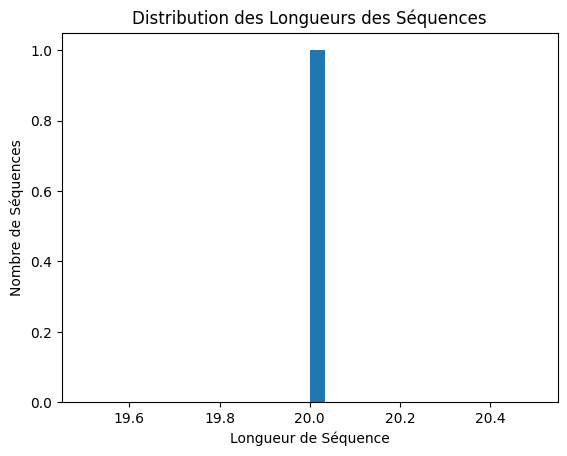

In [20]:
# Visualisation de la distribution des longueurs des séquences
import matplotlib.pyplot as plt
plt.hist(seq_lengths, bins=30)
plt.xlabel('Longueur de Séquence')
plt.ylabel('Nombre de Séquences')
plt.title('Distribution des Longueurs des Séquences')
plt.show()


In [21]:
print(max_sequence_length)

20


In [22]:
# Hyperparamètres et dimensions des données*
taille_num_features = data_num_rfecv.shape[1]
taille_text_features = max_sequence_length # je donne la taille max parmi les longueur des sequences
vocab_size = 20000  
embedding_dim = 128  

In [23]:
from tensorflow.keras.layers import *
import tensorflow as tf



# Entrées
input_num = tf.keras.layers.Input(shape=(taille_num_features,))
input_text = tf.keras.layers.Input(shape=(taille_text_features,))


# Branches du modèle
# Branche numérique - FFN

num_branch = tf.keras.layers.Dense(64, activation='relu')(input_num)
num_branch = tf.keras.layers.Dense(32, activation='relu')(num_branch)



# Branche textuelle - Embedding + Transformer (Un block)

text_branch = Embedding(vocab_size, embedding_dim, input_length=taille_text_features)(input_text)

mask_inputs = masque_remplissage(input_text) 

num_blocks = 4
out_seq = text_branch  # Initialisation avec les embeddings
for _ in range(num_blocks):
    out_seq = Encodeur(
            n_layers=4,
            d_model=128,
            num_heads=8,
            middle_units=256,
            max_seq_len=taille_text_features)([text_branch, mask_inputs])
out_seq = GlobalAveragePooling1D()(out_seq)
out_seq = Dropout(0.3)(out_seq)


# Fusion des branches 

flattened_text_branch = tf.keras.layers.Flatten()(text_branch) # je remodelise les dimension
merged = tf.keras.layers.concatenate([num_branch, flattened_text_branch])

# merged = layers.add([num_branch, text_branch])
# merged = layers.subtract([num_branch, text_branch])
# merged = layers.multiply([num_branch, text_branch])




# Couches supplémentaires après la fusion
merged = tf.keras.layers.Dropout(0.5)(merged)
merged = tf.keras.layers.Dense(16, activation='relu')(merged)

output = tf.keras.layers.Dense(1, activation='sigmoid')(merged)


# Création et compilation du modèle
model = Model(inputs=[input_num, input_text], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           704         ['input_1[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 20, 128)      2560000     ['input_2[0][0]']                
                                                                                              

In [24]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Entrées pour l'entraînement
data_num = data_num_rfecv   
data_text = pad_sequences(tokens, maxlen=max_length,padding='post')



In [25]:
# Assurez-vous que les données numériques sont correctes
print("Shape of data_num:", data_num.shape)

# Assurez-vous que les données textuelles sont correctes après le rembourrage
print("Shape of data_text:", data_text.shape)

# Assurez-vous que les étiquettes sont correctes
print("Shape of labels:", y.shape)

# NB utiliser le resultat obtenu pour modifier les tailles ou dimension de mes entrées definie plus haut


Shape of data_num: (433364, 10)
Shape of data_text: (433364, 20)
Shape of labels: (433364,)


In [26]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder


# 6. Encodage des étiquettes
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [27]:
from sklearn.model_selection import train_test_split

# 7. Diviser les données en ensembles d'entraînement et de test
X_train_numerical, X_test_numerical, X_train_categorical, X_test_categorical, y_train, y_test = train_test_split(data_num, data_text, y_encoded, test_size=0.2, random_state=32)

In [28]:
history = model.fit([X_train_numerical,X_train_categorical], y_train, epochs=5, batch_size=128, validation_data=([X_test_numerical,X_test_categorical], y_test))


Train on 346691 samples, validate on 86673 samples
Epoch 1/5
346691/346691 [==============================] - ETA: 0s - loss: 0.3383 - accuracy: 0.8645

c:\python install\lib\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


346691/346691 [==============================] - 204s 589us/sample - loss: 0.3383 - accuracy: 0.8645 - val_loss: 0.3141 - val_accuracy: 0.8729
Epoch 2/5
346691/346691 [==============================] - 201s 580us/sample - loss: 0.3176 - accuracy: 0.8728 - val_loss: 0.3122 - val_accuracy: 0.8731
Epoch 3/5
346691/346691 [==============================] - 189s 546us/sample - loss: 0.3149 - accuracy: 0.8730 - val_loss: 0.3158 - val_accuracy: 0.8733
Epoch 4/5
346691/346691 [==============================] - 181s 521us/sample - loss: 0.3129 - accuracy: 0.8733 - val_loss: 0.3122 - val_accuracy: 0.8734
Epoch 5/5
346691/346691 [==============================] - 181s 521us/sample - loss: 0.3120 - accuracy: 0.8733 - val_loss: 0.3097 - val_accuracy: 0.8734


In [29]:

#on effectue les prediction sur les donnees de test

y_pred = model.predict([X_test_numerical,X_test_categorical])

print(y_pred)

c:\python install\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[[0.95552754]
 [0.19810484]
 [0.9957135 ]
 ...
 [0.19390282]
 [0.9999491 ]
 [0.19317114]]


In [30]:
# necessaire pour afficher la matrix de confusion car a besoin que la probabilité retourner pqr lq fonction sigmoid soir saoit 0 ou 1 pour travailler dessus

y_pred = np.round(y_pred)

In [31]:
# Évaluation du modèle sur les données de test
evaluation_results = model.evaluate([X_test_numerical, X_test_categorical], y_test)
# loss, accuracy = model.evaluate([num_test, text_test], y_pred)


# Affichage des résultats

# print(f'Accuracy: {accuracy}, Loss: {loss}')
print("Perte sur les données de test:", evaluation_results[0])
print("Précision sur les données de test:", evaluation_results[1])


from sklearn.metrics import classification_report


# Afficher le rapport de classification
class_report = classification_report(y_test, y_pred)
print("Rapport de classification :\n", class_report)



Perte sur les données de test: 0.14096527047385768
Précision sur les données de test: 1.0
Rapport de classification :
               precision    recall  f1-score   support

           0       0.82      1.00      0.90     50183
           1       0.99      0.70      0.82     36490

    accuracy                           0.87     86673
   macro avg       0.91      0.85      0.86     86673
weighted avg       0.89      0.87      0.87     86673



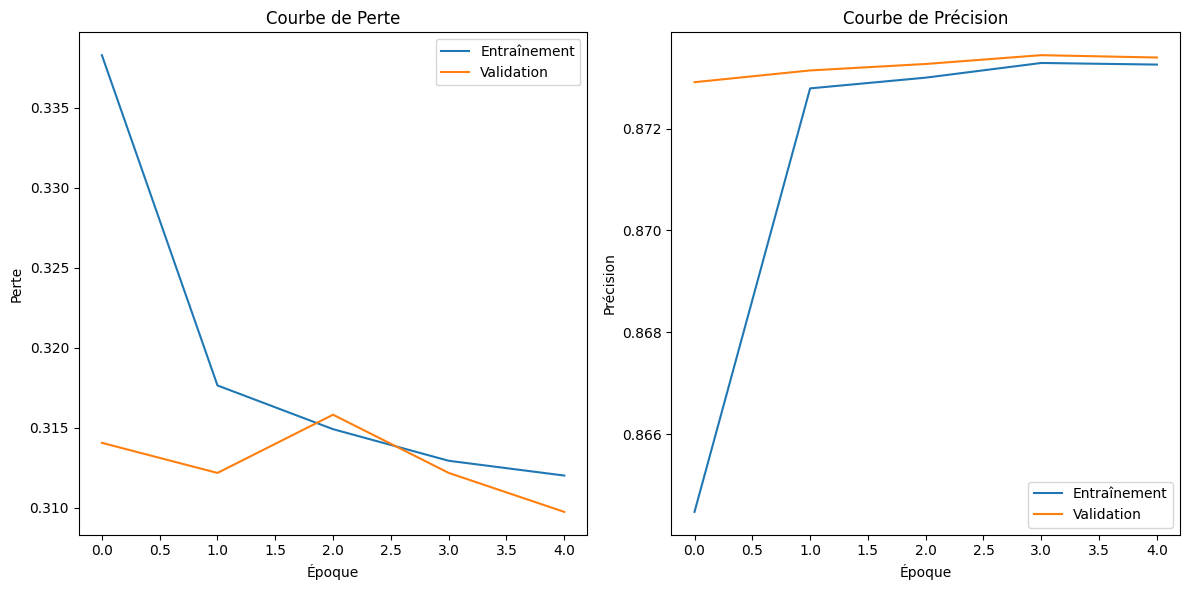

In [32]:
# Extraction des métriques d'entraînement
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Affichage des courbes de perte et d'exactitude séparément
epochs = range(1, len(loss) + 1)


# Affichage des courbes d'apprentissage et de validation
plt.figure(figsize=(12, 6))

# Plot de la perte d'entraînement et de la perte de validation
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Courbe de Perte')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()


# Plot de la précision d'entraînement et de la précision de validation
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entraînement')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Courbe de Précision')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()

# Afficher les deux sous-plots
plt.tight_layout()
plt.show()